## Choose Devise

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Quadro P5000


## Import Libraries

In [2]:
pip install pytorch-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 43.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895242 sha256=407e8682f448cb3a71f78aceb2d05db0a26c4d358c6d3c373b1053e1e2fabf51
  Stored in directory: /root/.cache/pip/wheels/42/79/78/5ad3b042cb2d97c294535162cdbaf9b167e3b186eae55ab72d
Successfully built sacremoses
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install transformers

In [4]:
import torch
import os
import string
import copy
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report
from pytorch_transformers import *
import numpy as np
import json
import collections
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [5]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## Import Dataset

In [6]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("hindi-wsd_train.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
# df.sample(10)
df1 = df
print(df1.shape)
#Labels - 1 for True and 0 for False

Number of training sentences: 7,000

(7000, 9)


In [7]:
df1.head(10)

,target_word,word_index,context_instance1,context_instance2,start1,end1,start2,end2,labels
0,कलम,8,इसमें पहली बार बालक के सिर और कलम के बाल उतार...,इसलिए साहित्यकार को सरकार के समाजवादी कार्यक्...,391,34,279,169,0
1,कांड,9,दूसरे दिन पुलिस ने इस हत्या कांड के सिलसिले म...,भानुभक्त कृत रामायण की कथा अध्यात्म रामायण पर...,482,224,348,156,0
2,अंग,1,इनमें बैंकों की परम्पराओं का भी निर्वाह किया ...,हाथ के किसी उपकरण (औजार) से किसी चीज को इच्छि...,453,346,571,333,0
3,खान,14,जयपुर. गुरु पूर्णिमा महोत्सव के तहत अमरूदों क...,माय नेम इज खान फिल्म कैसी बनी है? अभी किसी भ...,601,283,709,243,0
4,अंग,1,छवि कलाकारी को एक विशेष रूप सुंग काल में दिया...,जनवरीमें समस्त वाणिज्य बैंकों को सूचित किया ग...,813,800,406,198,0
5,दर,38,शलभ भी प्राय: रात के समय निकलते हैं इनका एक ज...,इराक़ बारबार कहता आया है कि वह हथियार निरीक्ष...,531,455,581,566,0
6,गुरु,17,लेकिन कहीं न कहीं उनकी बुराइयों की जड़ में राज...,गुरु मंत्र का जाप करना गुरु की शुभता प्राप्त ...,476,348,360,224,0
7,जीना,24,यदि सीढ़ियाँ चक्राकार सर्पिल हों तो 'ची' ऊर्जा...,पिछले सप्ताह एक के बाद एक तीन निकट सम्बन्धियो...,423,230,623,521,0
8,कलम,8,इसलिए साहित्यकार को सरकार के समाजवादी कार्यक्...,एक गुच्छा दूसरे से भिन्न होता है यदि एक मीटर ...,279,169,549,297,0
9,कुंभ,10,उनका कार्यक्षेत्र और कार्य करने की परिसीमा कु...,जब हम सनमें नासिक रहने के लिये आये तब ये शहरम...,326,236,502,68,0


In [8]:
# check class distribution
df['labels'].value_counts(normalize = True)

0    0.5
1    0.5
Name: labels, dtype: float64

In [9]:
sentences1= df1.context_instance1.values
sentences2= df1.context_instance2.values
words= df1.target_word.values
labels = df1.labels.values

<AxesSubplot: >

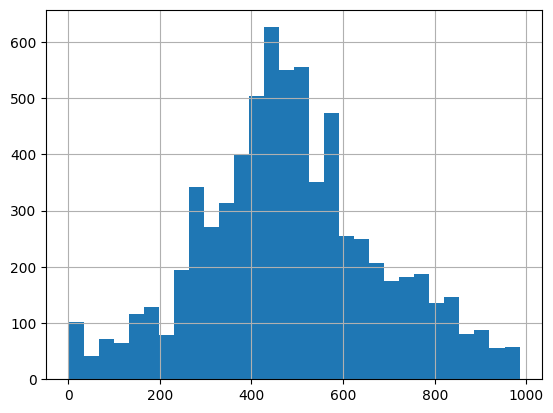

In [10]:
# get length of all the sentences
seq_len = [len(i) for i in sentences1]

pd.Series(seq_len).hist(bins = 30)

## Import Model & Model Tokenizer | Model Definition

### List of models present in the experiment:
The below models specified were used for the purpose to understand how the models perform when trained and tested on the Hindi Language:


* xlm-roberta-base

Please remove the # character to run the chosen model.

In [11]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
model_name='xlm-roberta-base'
print(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

xlm-roberta-base


In [12]:
 model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels = 2, # The number of output labels--2 for binary classification.
    # output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)
model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

## Create Train Dataset

The below functions will find the range of indexes of the target words from the two context sentences

In [13]:
def find_indexes_before(list1, list2):
    index = 0
    while index <= len(list1) - len(list2):
        if list1[index:index + len(list2)] == list2:
            return list(range(index, index + len(list2)))
        index += 1
    return []

def find_indexes_after(list1, before_length,list2):
    index = 0
    while index <= len(list1) - len(list2):
        if list1[index:index + len(list2)] == list2:
            #print(index)
            return list(range(index +before_length, index +before_length +  len(list2)))
        index += 1
    return []

The below function creates the dataset in the required format that is it contains a dictionary of lists with:
1. Input IDs -  sequence of integer tokens that represent the input text. Each token in the text is mapped to a unique integer ID based on a tokenizer. BERT uses a fixed-size vocabulary, and each token in the text is converted to its corresponding ID from the vocabulary.

2. Attention mask - binary mask tensor that indicates which tokens in the input should be attended to (receive attention) and which tokens should be ignored. It is used to handle variable-length input sequences. The mask has the same length as the input sequence and contains 0s and 1s

3. Target Word Location in sentence 1 - used to extract embeddings of target word from sentence 1

4. Target Word Location in sentence 2 - used to extract embeddings of target word from sentence 2

5. Labels


In [19]:

def create_data_set(sentences1,sentences2,words,labels):
    wic_padded=[]
    for i in range(0,len(sentences1)):

        #print(words[i])
        sentence = f"<s> {sentences1[i]}</s><s>{sentences2[i]}</s>"
        #print(sentence)
        tokens=tokenizer(sentence, add_special_tokens=False,pad_to_max_length=True,
                  truncation=True,max_length=512)
        input_ids = tokens["input_ids"]
        attention_mask = tokens["attention_mask"]
        #print(input_ids)
        target_word=words[i]
        target_token = tokenizer.encode(target_word)
        target_token=target_token[1:-1]
        #if running code for xlm roberta base
        s_token_index = tokenizer.convert_tokens_to_ids('</s>')
        sep_occurrences = [index for index, token_id in enumerate(input_ids) if token_id == s_token_index]

        #print(sep_occurrences)
        #break
        if len(sep_occurrences)!=0:
            sep_index = sep_occurrences[0]
            #print(sep_index)
            tokens_before_sep = input_ids[:sep_index]
            tokens_after_sep = input_ids[sep_index + 1:]
            #print(tokens_before_sep,tokens_after_sep)
            is_present1= str(target_token).replace("[","").replace("]","") in str(tokens_before_sep)
            is_present2= str(target_token).replace("[","").replace("]","") in str(tokens_after_sep)
            #print(target_token)
            #print(is_present1,is_present2)

            if is_present1!=False and is_present2!=False:
                #print(is_present1,is_present2)
                target_word_ids_before_sep = find_indexes_before(tokens_before_sep,target_token)
                target_word_ids_after_sep = find_indexes_after(tokens_after_sep,len(tokens_before_sep)-1,target_token)


                mask_tensor_sent1 = torch.zeros_like(torch.tensor(input_ids))
                mask_tensor_sent1[target_word_ids_before_sep] = 1
                mask_tensor_sent2 = torch.zeros_like(torch.tensor(input_ids))
                mask_tensor_sent2[target_word_ids_after_sep] = 1
                sample_data = {
                                "input_ids": torch.tensor(input_ids),
                                "attention_mask": torch.tensor(attention_mask),
                                "word1_locs": mask_tensor_sent1,
                                "word2_locs": mask_tensor_sent2,
                                "labels": torch.tensor(labels[i]),
                                "sentence": sentence,
                                "target_word":words[i]
                            }
            #break
                # Append the data for the current sample to the list
                wic_padded.append(sample_data)
                # wic_padded["input_ids"].append(torch.tensor(input_ids))
                # wic_padded["attention_mask"].append(torch.tensor(attention_mask))
                # wic_padded["word1_locs"].append(mask_tensor_sent1)
                # wic_padded["word2_locs"].append(mask_tensor_sent2)
                # wic_padded["labels"].append(labels[i])
    return wic_padded

In [20]:
#create training dataset
wic_train_set = create_data_set(sentences1,sentences2,words,labels)

In [21]:
print(len(wic_train_set))
BATCH_SIZE = 16

6708


In [22]:
train_labels=[]
for i in wic_train_set:
    x=i["labels"].item()
    train_labels.append(x)


In [23]:
print(len(train_labels))

6708


In [29]:
for i in wic_train_set:
    x=i["word1_locs"]
    y=i["word2_locs"]
    print("sentence: ",i["sentence"])
    print("target_word: ",i["target_word"])
    print("word1 location: ",x)
    print("word2 location: ",y)
    break

sentence:  <s>  इसमें पहली बार बालक के सिर और कलम के बाल उतारे जाते हैं यह कार्य जन्म से एक वर्ष या तीन वर्ष बाद या परिवार की परंपरा के आधार पर और बाद में हो सकता है चरक का विचार है कि केश श्मश्रु एवं नखों के काटने एवं प्रसाधन से पौष्टिकता बल आयुष्य शुचिता और सौंदर्य की प्राप्ति होती है इस संस्कार के पीछे स्वास्थ्य एवं सौंदर्य की भावना ही प्रमुख थी पहले यह घर पर होता था किंतु बाद में देवालयों में </s><s> इसलिए साहित्यकार को सरकार के समाजवादी कार्यक्रम में शामिल होने का पूरा हक है मगर सरकार समाजवादी हो तभी अन्यथा नहीं साहित्यकार को यथास्तिथि को तोड़ना है वह इस काम को कलम से तो करेगा ही जुलूस मेंसभा मेंशामिल होकर भीमत व्यक्त करके भी सही को प्रस्तुत करना उसका कर्त्तव्य हो जाता है</s>
target_word:  कलम
word1 location:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [30]:
len(wic_train_set)

6708

In [24]:
train_data = TensorDataset(
    torch.stack([sample["input_ids"] for sample in wic_train_set]),
    torch.stack([sample["attention_mask"] for sample in wic_train_set]),
    torch.stack([sample["word1_locs"] for sample in wic_train_set]),
    torch.stack([sample["word2_locs"] for sample in wic_train_set]),
    torch.stack([sample["labels"] for sample in wic_train_set])
)

# Create a random sampler and loader
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

## Create Validation Dataset

In [25]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("hindi-wsd_val.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
# df.sample(10)
df1 = df
print(df1.shape)
#Labels - 1 for True and 0 for False

Number of training sentences: 3,000

(3000, 9)


In [26]:
sentences_val1= df1.context_instance1.values
sentences_val2= df1.context_instance2.values
words_val= df1.target_word.values
labels_val = df1.labels.values

In [27]:
print(len(sentences_val1))

3000


In [28]:
#create validation dataset

wic_val_set = create_data_set(sentences_val1,sentences_val2,words_val,labels_val)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [29]:
print(len(wic_val_set))

2924


In [30]:
val_data = TensorDataset(
    torch.stack([sample["input_ids"] for sample in wic_val_set]),
    torch.stack([sample["attention_mask"] for sample in wic_val_set]),
    torch.stack([sample["word1_locs"] for sample in wic_val_set]),
    torch.stack([sample["word2_locs"] for sample in wic_val_set]),
    torch.stack([sample["labels"] for sample in wic_val_set])
)

# Create a sampler and loader
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

## Model Architecture

In [31]:

class WiC_Head(torch.nn.Module):
    def __init__(self, model_used,weights,embedding_size=768):
        super(WiC_Head, self).__init__()
        self.model=model_used
        self.embedding_size = embedding_size
        self.linear_diff = torch.nn.Linear(embedding_size, 100, bias=True)
        self.linear_seperator = torch.nn.Linear(100, 2, bias=True)
        self.loss = torch.nn.CrossEntropyLoss(weight=weights)
        self.activation = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

        self.to(device)
        self.linear_diff.to(device)
        self.loss.to(device)
        self.linear_seperator.to(device)
        self.activation.to(device)
        self.softmax.to(device)

    def forward(self, input_ids=None, attention_mask=None, word1_locs=None, word2_locs=None, labels=None):
        batch_size = input_ids.shape[0]
        input_ids_tensor = input_ids.to(device)
        attention_mask_tensor = attention_mask.to(device)

        word1_locs = word1_locs.to(device)
        word1_locs=word1_locs.unsqueeze(1)

        word2_locs = word2_locs.to(device)
        word2_locs=word2_locs.unsqueeze(1)

        outputs=model(input_ids_tensor,attention_mask_tensor)

        token_embeddings=outputs.hidden_states[-1]
        token_embeddings = torch.squeeze(token_embeddings, dim=0)

        word1_embs=torch.matmul(word1_locs.float(),token_embeddings.float()).view(batch_size, self.embedding_size)
        word2_embs=torch.matmul(word2_locs.float(),token_embeddings.float()).view(batch_size, self.embedding_size)

        diff = word1_embs - word2_embs

        layer1_results = self.activation(self.linear_diff(diff))
        logits = self.softmax(self.linear_seperator(layer1_results))
        if labels is not None:
            loss = self.loss(logits.view(-1, 2).to(device), labels.view(-1).to(device))
            outputs = (loss, logits)
        return outputs


We need to ensure that both classes are assigned weights accordingly in case any class in our dataset over represented

In [32]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=[0,1], y=train_labels)

print(class_wts)

weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

[0.99084195 1.00932892]


In [33]:
class_model = WiC_Head(model, weights,embedding_size = 768)

class_model.to(device)

WiC_Head(
  (model): XLMRobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in

## Optimization Function

I used an improved version of the Adam Optimizer called AdamW for the below reasons:

AdamW is an adaptation of the Adam optimizer, designed to incorporate the weight decay (L2 regularization) term directly into the optimization process. The "W" in AdamW stands for "weight decay." 

In [34]:

param_optimizer = list(class_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=1e-5)

## Fine Tune the Model

In [35]:
torch.cuda.empty_cache()

In [36]:
BATCH_SIZE = 16 #decreased the size until the CPU stops dying
EPOCHS = 10 #could do more for higher accuracy buts takes too long

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels, return_predict_correctness = False):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    if return_predict_correctness:
        return np.sum(pred_flat == labels_flat) / len(labels_flat), pred_flat == labels_flat
    else:
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

best_weights = class_model.state_dict()
logits_train=[]
labels_train=[]
logits_test=[]
labels_test=[]

# maximize from 0
max_val_acc = (0, 0)

# Store our loss and accuracy for plotting
train_loss=[]
train_accuracy=[]
val_loss=[]
val_accuracy=[]
epoch_number = 0

while epoch_number < EPOCHS:
    epoch_number += 1
    print(f"Training epoch #{epoch_number}")

    # Tracking variables
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Training
    class_model.train()

    #class_model.embedder.requires_grad_ = False
    # Train the data for each epoch
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_word1, b_word2, b_labels = batch
        #reset gradient
        optimizer.zero_grad()
        # get input and compute loss
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_word1 = b_word1.to(device)
        b_word2 = b_word2.to(device)
        b_labels=b_labels.to(device)
        loss, logits = class_model(input_ids=b_input_ids, attention_mask=b_input_mask, word1_locs = b_word1, word2_locs = b_word2,labels=b_labels)
        torch.cuda.empty_cache()
        # get gradient
        loss.backward()
        #accelerator.backward(loss)
        # Update model
        optimizer.step()

        logits = logits.detach().cpu().numpy()
        logits_train.append(logits)
        label_ids = b_labels.cpu().numpy()
        labels_train.append(label_ids)
        # Calculate the accuracy
        b_accuracy = flat_accuracy(logits, label_ids) # For RobertaForClassification
        # Append to fit history
        train_loss.append(loss.item())
        train_accuracy.append(b_accuracy)
        # Update tracking variables
        tr_loss += loss.item()
        tr_accuracy += b_accuracy
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Training:\n\tLoss: {}; Accuracy: {}".format(tr_loss/nb_tr_steps, tr_accuracy/nb_tr_steps))

    # Validation
    class_model.eval()
    # Evaluate data for one epoch
    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_word1, b_word2, b_labels  = batch
        # don't store gradients
        with torch.no_grad():
          # get input and compute loss
            loss, logits = class_model(b_input_ids, attention_mask=b_input_mask, word1_locs = b_word1, word2_locs = b_word2,labels=b_labels)
            #print(logits)
        logits = logits.detach().cpu().numpy()
        logits_test.append(logits)
        label_ids = b_labels.cpu().numpy()
        labels_test.append(label_ids)
        # Calculate the accuracy
        b_accuracy = flat_accuracy(logits, label_ids) # For RobertaForClassification

        # Append to fit history
        val_loss.append(loss.item())
        val_accuracy.append(b_accuracy)
        # Update tracking variables
        eval_loss += loss.item()
        eval_accuracy += b_accuracy
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_acc = eval_accuracy/nb_eval_steps
    if eval_acc >= max_val_acc[0]:
        max_val_acc = (eval_acc, epoch_number)

    print("Validation:\n\tLoss={}; Accuracy: {}".format(eval_loss/nb_eval_steps, eval_accuracy/nb_eval_steps))
print(f"Best Validation accuracy ({max_val_acc[0]}) obtained at epoch #{max_val_acc[1]}.")
# Reload the best weights (from memory)
class_model.load_state_dict(best_weights)

Training epoch #1


/tmp/ipykernel_32/676167891.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.softmax(self.linear_seperator(layer1_results))


Training:
	Loss: 0.6934260234946297; Accuracy: 0.49583333333333335
Validation:
	Loss=0.6937168357802219; Accuracy: 0.446379781420765
Training epoch #2
Training:
	Loss: 0.6936487220582508; Accuracy: 0.49776785714285715
Validation:
	Loss=0.6936477341287123; Accuracy: 0.4418260473588343
Training epoch #3
Training:
	Loss: 0.6932335677601043; Accuracy: 0.4928571428571429
Validation:
	Loss=0.693821615534402; Accuracy: 0.44193989071038253
Training epoch #4


KeyboardInterrupt: 

In [47]:
PATH = 'saved_weights_xlmr.pt'
torch.save(class_model.state_dict(), PATH)

## Test the Model

In [49]:

# Load the dataset into a pandas dataframe.
df = pd.read_csv("hindi-wsd_test.csv")
df.head(10)
df1=df.sample(2000)

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df1.shape[0]))


sentences11= list(df1.context_instance1.values)
sentences12= list(df1.context_instance2.values)
words1= list(df1.target_word.values)
labels1 = list(df1.labels.values)

Number of test sentences: 2,000



In [50]:
l2=[]
for i in range(0,len(sentences1)):
    l2.append(sentences1[i]+"#"+sentences2[i])
    l2.append(sentences2[i]+"#"+sentences1[i])
print(l2[0])

 इसमें पहली बार बालक के सिर और कलम के बाल उतारे जाते हैं यह कार्य जन्म से एक वर्ष या तीन वर्ष बाद या परिवार की परंपरा के आधार पर और बाद में हो सकता है चरक का विचार है कि केश श्मश्रु एवं नखों के काटने एवं प्रसाधन से पौष्टिकता बल आयुष्य शुचिता और सौंदर्य की प्राप्ति होती है इस संस्कार के पीछे स्वास्थ्य एवं सौंदर्य की भावना ही प्रमुख थी पहले यह घर पर होता था किंतु बाद में देवालयों में # इसलिए साहित्यकार को सरकार के समाजवादी कार्यक्रम में शामिल होने का पूरा हक है मगर सरकार समाजवादी हो तभी अन्यथा नहीं साहित्यकार को यथास्तिथि को तोड़ना है वह इस काम को कलम से तो करेगा ही जुलूस मेंसभा मेंशामिल होकर भीमत व्यक्त करके भी सही को प्रस्तुत करना उसका कर्त्तव्य हो जाता है


In [51]:
l1=[]
print(len(sentences11))

l2=set(l2)
for i in range(0,len(sentences11)):
    k=sentences12[i]+"#"+sentences11[i]
    if k in l2:
        l1.append(i)
print(len(l1))
l1.sort(reverse=True)

for i in l1:
    del sentences11[i]
    del sentences12[i]
    del words1[i]
    del labels1[i]
print(len(sentences11))



2000
102
1898


In [52]:
#create test dataset
sentences11= np.array(sentences11)
sentences12= np.array(sentences12)
words1= np.array(words1)
labels1 = np.array(labels1)

wic_test_set = create_data_set(sentences11,sentences12,words1,labels1)
print(len(wic_test_set))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1824


In [53]:
test_data = TensorDataset(
    torch.stack([sample["input_ids"] for sample in wic_test_set]),
    torch.stack([sample["attention_mask"] for sample in wic_test_set]),
    torch.stack([sample["word1_locs"] for sample in wic_test_set]),
    torch.stack([sample["word2_locs"] for sample in wic_test_set]),
    torch.stack([sample["labels"] for sample in wic_test_set])
)

# Create a sampler and loader
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
#load weights of best model
path = 'saved_weights_xlmr.pt'
class_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [54]:
# get predictions for test data
class_model.eval()
total_preds=[]
test_labels1=[]
with torch.no_grad():
    for batch in test_dataloader:
        batch = [t.to(device) for t in batch]
        test_ids, test_mask, test_word1, test_word2, test_labels = batch
        _,logits = class_model(test_ids, test_mask, test_word1, test_word2, test_labels)
        logits=logits.detach().cpu().numpy()
        test_labels1.append(test_labels.detach().cpu().numpy())
        #print(logits)
        preds = np.argmax(logits, axis=1).flatten()
        total_preds.append(preds)

<ipython-input-41-09335e4de85a>:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.softmax(self.linear_seperator(layer1_results))


In [55]:
total_preds1=[]
for i in total_preds:
    for i1 in i:
        total_preds1.append(i1)

print(len(total_preds1))

test_labels2=[]
for i in test_labels1:
    for i1 in i:
        test_labels2.append(i1)

print(len(test_labels2))

1824
1824


In [56]:
# model's performance
#preds = np.argmax(preds, axis = 1)
print(classification_report(test_labels2, total_preds1))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1067
           1       0.89      0.78      0.83       757

    accuracy                           0.87      1824
   macro avg       0.87      0.86      0.86      1824
weighted avg       0.87      0.87      0.87      1824

